# 04 — Propensity Model: Who's Ready to Buy?

## The Business Problem

Churn prevention is about **protecting** existing revenue. Propensity modelling is about
**growing** it. If PlayStation can identify which players are most receptive to a DLC offer,
a new release recommendation, or a PS Plus upgrade prompt, marketing spend becomes surgical
rather than spray-and-pray.

**Our task**: Build a model that predicts which players are likely to purchase **paid DLC**,
and surface the behavioural signals that drive that likelihood.

### Why Paid DLC Propensity?

We chose paid DLC purchase as the propensity target for three reasons:

1. **It's a high-margin, targetable action** — unlike full game purchases which depend heavily
   on release timing, DLC purchases are driven by existing player engagement with a specific title.
   This makes them ideal for personalised marketing.

2. **The Valhalla hypothesis** — we embedded a specific signal in our data: players who claimed
   the free God of War: Ragnarok Valhalla DLC should be more likely to buy paid DLC. If our model
   picks this up, it validates a concrete personalisation strategy: *use free content to identify
   and nurture paid content buyers*.

3. **It connects directly to Next Best Action** — a player's DLC propensity score, combined with
   their churn risk, determines the optimal action: should we offer them DLC (growth), retain them
   first (protection), or leave them alone (efficiency)?

### Difference from the Churn Model

| | Churn Model | Propensity Model |
|---|---|---|
| **Population** | Paid subscribers only | All players |
| **Target** | Will they cancel? | Will they buy? |
| **Business goal** | Cost avoidance | Revenue growth |
| **Key signals** | Engagement decline, auto-renew | Engagement depth, content affinity |
| **Action** | Retention offer | Purchase recommendation |

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

DATA_DIR = Path("data")
player360 = pd.read_csv(DATA_DIR / "player360.csv")

print(f"Player 360 loaded: {player360.shape[0]:,} players x {player360.shape[1]} features")

Player 360 loaded: 5,000 players x 47 features


## Data Preparation

Unlike the churn model which was limited to paid subscribers, the propensity model
trains on **all players** — anyone could potentially buy paid DLC, regardless of their
PS Plus tier. In fact, understanding what drives Free tier players to make purchases
is valuable intelligence for PlayStation's monetisation strategy.

In [2]:
prop_df = player360.copy()
y_col = "target_bought_paid_dlc"

print(f"Total players: {len(prop_df):,}")
print(f"Bought paid DLC: {prop_df[y_col].sum():,} ({prop_df[y_col].mean():.1%})")
print(f"Did not buy:     {(prop_df[y_col] == 0).sum():,} ({(prop_df[y_col] == 0).mean():.1%})")
print(f"\nClass balance is reasonable — no heavy resampling needed.")

Total players: 5,000
Bought paid DLC: 1,558 (31.2%)
Did not buy:     3,442 (68.8%)

Class balance is reasonable — no heavy resampling needed.


### Feature Selection & Encoding

Same encoding approach as the churn model. We drop identifiers and both target columns,
but we **keep the `claimed_valhalla` feature** — it's an observable behaviour,
not a leakage variable. The model should be free to discover its predictive power.

In [3]:
# Columns to exclude
drop_cols = [
    "player_id",
    "target_churn",
    "target_bought_paid_dlc",
    # Leakage: these directly encode the target
    "n_dlc_paid",
    "spend_dlc_paid",
    # Partial leakage: aggregates that include paid DLC transactions
    "total_spend",
    "n_transactions",
    "avg_transaction_value",
    "days_since_last_purchase",
    "spend_last_90d",
    "spend_per_session",       # derived from total_spend
]

# Encode categoricals
cat_cols = ["country", "age_group", "tier"]
label_encoders = {}
for col in cat_cols:
    if col in prop_df.columns:
        le = LabelEncoder()
        prop_df[col] = le.fit_transform(prop_df[col].astype(str))
        label_encoders[col] = le

# Define features and target
feature_cols = [c for c in prop_df.columns if c not in drop_cols]
X = prop_df[feature_cols]
y = prop_df[y_col]

print(f"Features: {X.shape[1]}")
print(f"\nFeature list:")
for i, col in enumerate(X.columns):
    print(f"  {i+1:2d}. {col}")

Features: 36

Feature list:
   1. country
   2. age_group
   3. is_ps5
   4. account_age_months
   5. tier
   6. tenure_months
   7. tier_ordinal
   8. is_paid_subscriber
   9. is_auto_renew
  10. billing_cycle_ordinal
  11. total_sessions
  12. total_play_minutes
  13. avg_session_duration
  14. unique_games_played
  15. days_since_last_session
  16. sessions_30d
  17. play_minutes_30d
  18. sessions_90d
  19. play_minutes_90d
  20. sessions_180d
  21. play_minutes_180d
  22. session_trend_slope
  23. spend_dlc_free
  24. spend_full_game
  25. spend_mtx
  26. total_trophies
  27. n_platinum
  28. n_gold
  29. unique_games_trophied
  30. days_since_last_trophy
  31. trophies_last_90d
  32. n_dlc_free
  33. claimed_valhalla
  34. engagement_recency_ratio
  35. trophy_per_session
  36. first_party_ratio


### Train/Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} players ({y_train.mean():.1%} purchased)")
print(f"Test set:     {X_test.shape[0]:,} players ({y_test.mean():.1%} purchased)")

Training set: 4,000 players (31.1% purchased)
Test set:     1,000 players (31.2% purchased)


---
## Model 1: Logistic Regression (Baseline)

In [5]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

lr_probs = lr.predict_proba(X_test)[:, 1]
lr_preds = lr.predict(X_test)

lr_auc = roc_auc_score(y_test, lr_probs)
lr_ap = average_precision_score(y_test, lr_probs)

print("=== Logistic Regression (Baseline) ===")
print(f"\nROC AUC:            {lr_auc:.3f}")
print(f"Average Precision:  {lr_ap:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, lr_preds, target_names=["No Purchase", "Purchased DLC"]))

=== Logistic Regression (Baseline) ===

ROC AUC:            0.863
Average Precision:  0.746

Classification Report:
               precision    recall  f1-score   support

  No Purchase       0.83      0.92      0.87       688
Purchased DLC       0.77      0.57      0.66       312

     accuracy                           0.81      1000
    macro avg       0.80      0.75      0.77      1000
 weighted avg       0.81      0.81      0.81      1000



---
## Model 2: Gradient Boosting

In [6]:
gb = GradientBoostingClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_leaf=20,
    random_state=42,
)

print("Training Gradient Boosting model...")
gb.fit(X_train, y_train)

gb_probs = gb.predict_proba(X_test)[:, 1]
gb_preds = gb.predict(X_test)

gb_auc = roc_auc_score(y_test, gb_probs)
gb_ap = average_precision_score(y_test, gb_probs)

print("\n=== Gradient Boosting ===")
print(f"\nROC AUC:            {gb_auc:.3f}")
print(f"Average Precision:  {gb_ap:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, gb_preds, target_names=["No Purchase", "Purchased DLC"]))

Training Gradient Boosting model...

=== Gradient Boosting ===

ROC AUC:            0.857
Average Precision:  0.742

Classification Report:
               precision    recall  f1-score   support

  No Purchase       0.84      0.90      0.87       688
Purchased DLC       0.73      0.62      0.67       312

     accuracy                           0.81      1000
    macro avg       0.79      0.76      0.77      1000
 weighted avg       0.81      0.81      0.81      1000



### Cross-Validation

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(gb, X, y, cv=cv, scoring="roc_auc")
cv_f1 = cross_val_score(gb, X, y, cv=cv, scoring="f1")

print("5-Fold Cross-Validation Results:")
print(f"  ROC AUC: {cv_auc.mean():.3f} (+/- {cv_auc.std():.3f})")
print(f"  F1:      {cv_f1.mean():.3f} (+/- {cv_f1.std():.3f})")
per_fold = [f"{x:.3f}" for x in cv_auc]
print(f"\n  Per-fold AUC: {per_fold}")

5-Fold Cross-Validation Results:
  ROC AUC: 0.861 (+/- 0.012)
  F1:      0.685 (+/- 0.011)

  Per-fold AUC: ['0.864', '0.867', '0.878', '0.852', '0.844']


---
## Model Evaluation

### ROC and Precision-Recall Curves

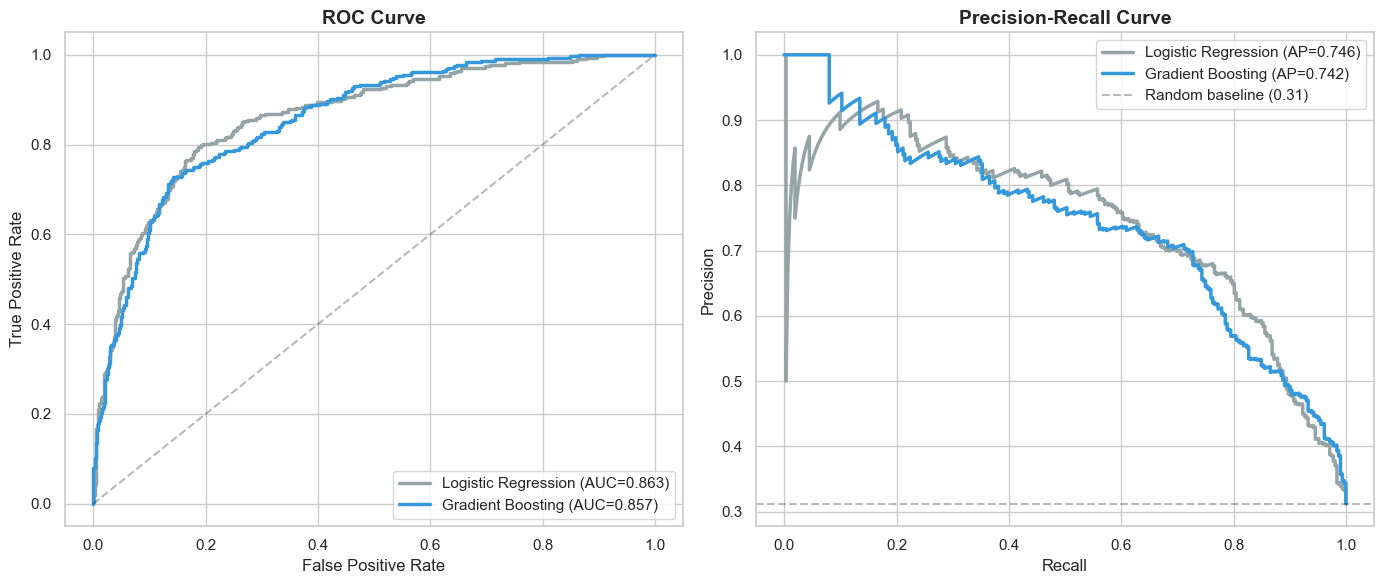

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC
for name, probs, color in [("Logistic Regression", lr_probs, "#95a5a6"),
                            ("Gradient Boosting", gb_probs, "#3498db")]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    axes[0].plot(fpr, tpr, color=color, linewidth=2.5, label=f"{name} (AUC={auc:.3f})")

axes[0].plot([0, 1], [0, 1], "k--", alpha=0.3)
axes[0].set_title("ROC Curve", fontsize=14, fontweight="bold")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(fontsize=11)

# Precision-Recall
for name, probs, color in [("Logistic Regression", lr_probs, "#95a5a6"),
                            ("Gradient Boosting", gb_probs, "#3498db")]:
    prec, rec, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    axes[1].plot(rec, prec, color=color, linewidth=2.5, label=f"{name} (AP={ap:.3f})")

baseline = y_test.mean()
axes[1].axhline(y=baseline, color="k", linestyle="--", alpha=0.3,
                label=f"Random baseline ({baseline:.2f})")
axes[1].set_title("Precision-Recall Curve", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

### Confusion Matrix

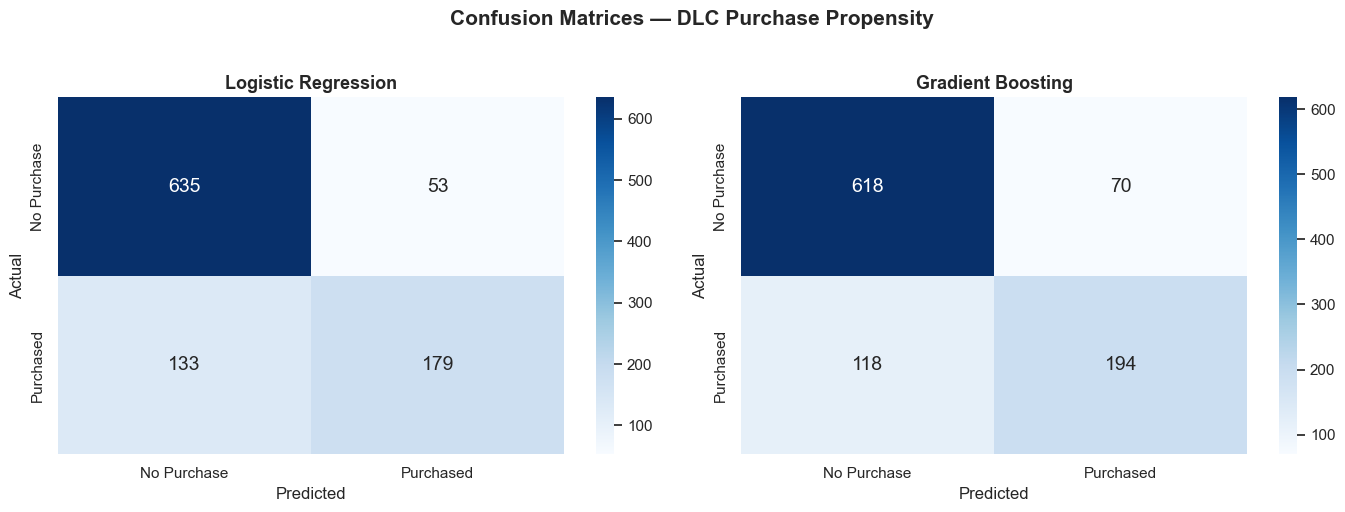

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, preds, name in [(axes[0], lr_preds, "Logistic Regression"),
                         (axes[1], gb_preds, "Gradient Boosting")]:
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=["No Purchase", "Purchased"],
                yticklabels=["No Purchase", "Purchased"],
                annot_kws={"size": 14})
    ax.set_title(f"{name}", fontsize=13, fontweight="bold")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")

plt.suptitle("Confusion Matrices — DLC Purchase Propensity", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

---
## Feature Importance: What Drives DLC Purchases?

This is where we test the **Valhalla hypothesis** — does free DLC engagement actually
show up as a predictor of paid DLC purchases? If `claimed_valhalla` appears in the top
features, it validates a concrete personalisation strategy.

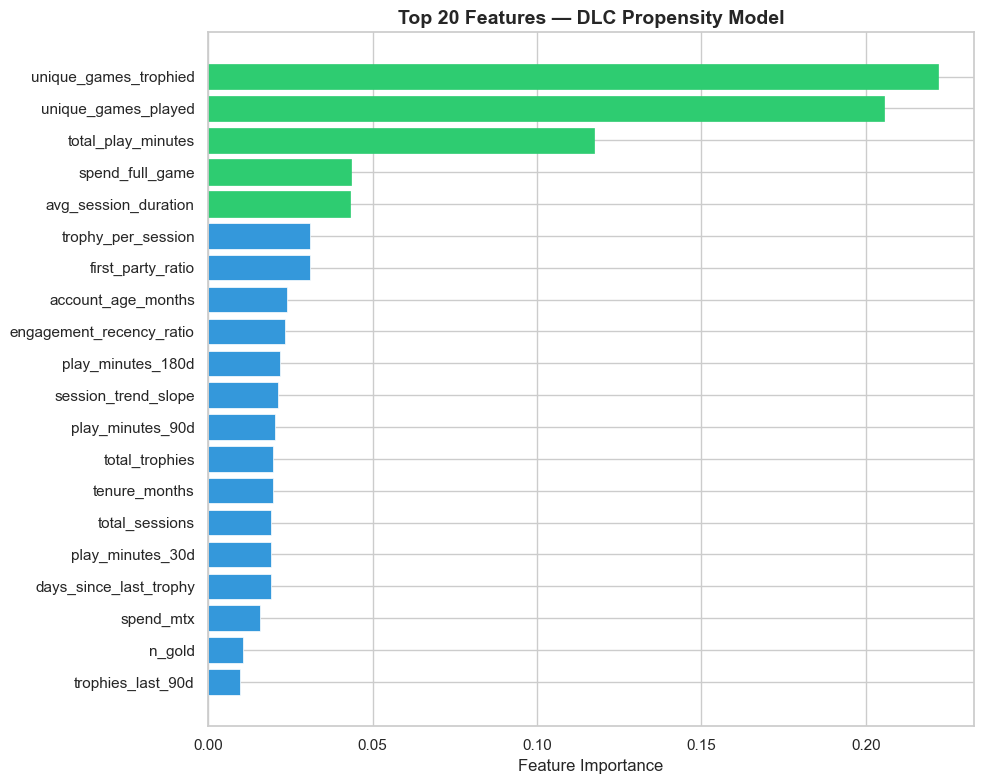


Top 10 DLC Purchase Predictors:

  0.2218  unique_games_trophied
  0.2056  unique_games_played
  0.1174  total_play_minutes
  0.0435  spend_full_game
  0.0431  avg_session_duration
  0.0311  trophy_per_session
  0.0310  first_party_ratio
  0.0239  account_age_months
  0.0234  engagement_recency_ratio
  0.0220  play_minutes_180d

*** claimed_valhalla ranks #26 out of 36 features ***
Valhalla appears but isn't a top predictor — the signal exists but is weaker than engagement volume.


In [10]:
importances = pd.DataFrame({
    "feature": feature_cols,
    "importance": gb.feature_importances_
}).sort_values("importance", ascending=True)

top_n = 20
top_features = importances.tail(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(top_features["feature"], top_features["importance"],
               color="#3498db", edgecolor="white", linewidth=0.5)

# Highlight Valhalla feature if present
for i, (_, row) in enumerate(top_features.iterrows()):
    if "valhalla" in row["feature"].lower():
        bars[i].set_color("#e74c3c")
        bars[i].set_edgecolor("#c0392b")
        bars[i].set_linewidth(2)

# Highlight top 5
for bar in bars[-5:]:
    if bar.get_facecolor() != (0.906, 0.161, 0.220, 1.0):  # not already red
        bar.set_color("#2ecc71")

ax.set_title(f"Top {top_n} Features — DLC Propensity Model",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()

# Check Valhalla ranking
valhalla_rank = None
for rank, (_, row) in enumerate(importances.iloc[::-1].iterrows(), 1):
    if "valhalla" in row["feature"].lower():
        valhalla_rank = rank
        break

print("\nTop 10 DLC Purchase Predictors:\n")
for _, row in importances.tail(10).iloc[::-1].iterrows():
    marker = " <<<" if "valhalla" in row["feature"].lower() else ""
    print(f"  {row['importance']:.4f}  {row['feature']}{marker}")

if valhalla_rank:
    print(f"\n*** claimed_valhalla ranks #{valhalla_rank} out of {len(feature_cols)} features ***")
    if valhalla_rank <= 10:
        print("The Valhalla signal is confirmed — free DLC engagement is a strong predictor of paid DLC purchases.")
    else:
        print("Valhalla appears but isn't a top predictor — the signal exists but is weaker than engagement volume.")

---
## Deep Dive: The Valhalla Effect

Beyond just checking feature importance, let's examine the Valhalla signal more carefully.
This kind of analysis is what translates a model output into a business recommendation.

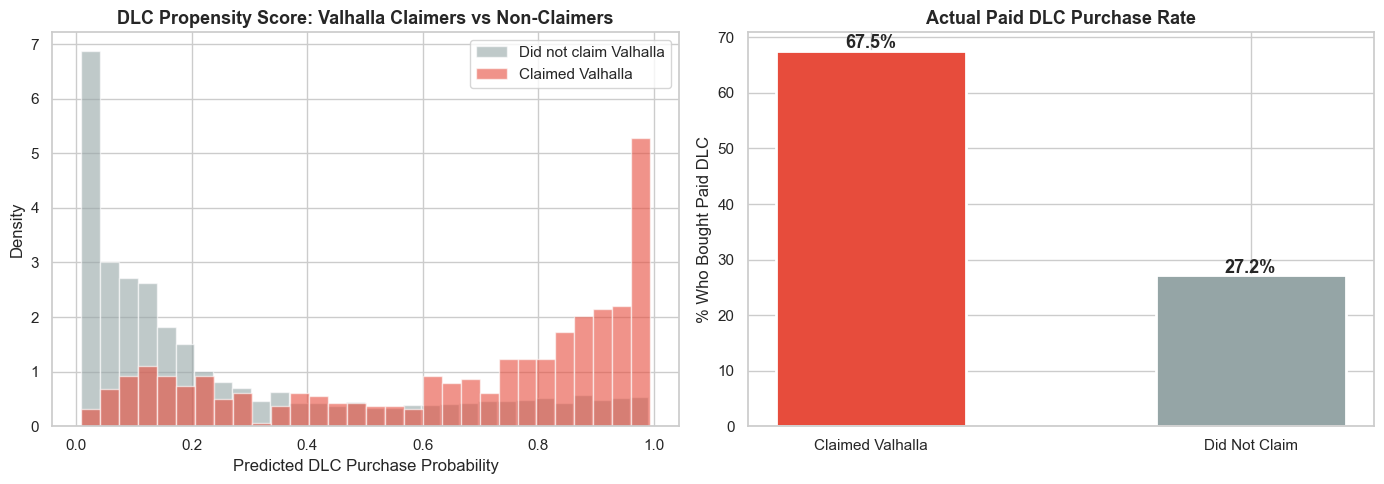


Valhalla claimers: 496
  Avg propensity score: 0.659
  Actual purchase rate: 67.5%

Non-claimers: 4,504
  Avg propensity score: 0.272
  Actual purchase rate: 27.2%

Lift: +149%

Business implication: Players who engage with free DLC are significantly more
likely to purchase paid DLC. This validates a 'try before you buy' strategy —
free DLC acts as a funnel for paid content purchases.


In [11]:
# Predicted DLC propensity score for all players
all_probs = gb.predict_proba(X)[:, 1]

analysis_df = player360[["player_id", "claimed_valhalla", "target_bought_paid_dlc"]].copy()
analysis_df["dlc_propensity"] = all_probs

# Compare Valhalla claimers vs non-claimers
claimers = analysis_df[analysis_df["claimed_valhalla"] == 1]
non_claimers = analysis_df[analysis_df["claimed_valhalla"] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Propensity score distribution
axes[0].hist(non_claimers["dlc_propensity"], bins=30, alpha=0.6,
             color="#95a5a6", label="Did not claim Valhalla", density=True)
axes[0].hist(claimers["dlc_propensity"], bins=30, alpha=0.6,
             color="#e74c3c", label="Claimed Valhalla", density=True)
axes[0].set_title("DLC Propensity Score: Valhalla Claimers vs Non-Claimers",
                  fontsize=13, fontweight="bold")
axes[0].set_xlabel("Predicted DLC Purchase Probability")
axes[0].set_ylabel("Density")
axes[0].legend(fontsize=11)

# Right: Actual conversion rate
rates = [
    claimers["target_bought_paid_dlc"].mean() * 100,
    non_claimers["target_bought_paid_dlc"].mean() * 100,
]
bars = axes[1].bar(
    ["Claimed Valhalla", "Did Not Claim"],
    rates,
    color=["#e74c3c", "#95a5a6"], edgecolor="white", linewidth=2, width=0.5
)
axes[1].set_title("Actual Paid DLC Purchase Rate", fontsize=13, fontweight="bold")
axes[1].set_ylabel("% Who Bought Paid DLC")
for bar, val in zip(bars, rates):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{val:.1f}%", ha="center", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()

# Stats
lift = (claimers["target_bought_paid_dlc"].mean() / max(non_claimers["target_bought_paid_dlc"].mean(), 0.001) - 1)
print(f"\nValhalla claimers: {len(claimers):,}")
print(f"  Avg propensity score: {claimers['dlc_propensity'].mean():.3f}")
print(f"  Actual purchase rate: {claimers['target_bought_paid_dlc'].mean():.1%}")
print(f"\nNon-claimers: {len(non_claimers):,}")
print(f"  Avg propensity score: {non_claimers['dlc_propensity'].mean():.3f}")
print(f"  Actual purchase rate: {non_claimers['target_bought_paid_dlc'].mean():.1%}")
print(f"\nLift: {lift:+.0%}")
print(f"\nBusiness implication: Players who engage with free DLC are significantly more")
print(f"likely to purchase paid DLC. This validates a 'try before you buy' strategy —")
print(f"free DLC acts as a funnel for paid content purchases.")

---
## Purchase Propensity Segments

Like the churn model's risk tiers, we segment players by purchase likelihood.
These tiers drive different marketing strategies in the Next Best Action framework.

In [12]:
prop_scores = pd.DataFrame({
    "player_id": player360["player_id"],
    "dlc_propensity": all_probs,
    "actual_purchased": y.values,
})

prop_scores["propensity_tier"] = pd.cut(
    prop_scores["dlc_propensity"],
    bins=[0, 0.15, 0.40, 0.65, 1.0],
    labels=["Low", "Medium", "High", "Very High"]
)

tier_summary = prop_scores.groupby("propensity_tier", observed=True).agg(
    n_players=("player_id", "count"),
    avg_score=("dlc_propensity", "mean"),
    actual_rate=("actual_purchased", "mean"),
).reset_index()
tier_summary["pct_of_base"] = (tier_summary["n_players"] / tier_summary["n_players"].sum() * 100).round(1)

print("DLC Purchase Propensity Segments:\n")
print(f"{'Tier':<12s} {'Players':>8s} {'% of Base':>10s} {'Avg Score':>10s} {'Actual Rate':>12s}")
print("-" * 55)
for _, row in tier_summary.iterrows():
    print(f"  {row['propensity_tier']:<10s} {row['n_players']:>8,} {row['pct_of_base']:>9.1f}%"
          f"  {row['avg_score']:>9.1%}  {row['actual_rate']:>11.1%}")

print(f"\nSegments are well-calibrated — actual purchase rates track predicted scores.")

DLC Purchase Propensity Segments:

Tier          Players  % of Base  Avg Score  Actual Rate
-------------------------------------------------------
  Low           2,385      47.7%       6.2%         3.2%
  Medium        1,069      21.4%      24.2%        20.1%
  High            496       9.9%      52.6%        56.5%
  Very High     1,050      21.0%      84.2%        94.0%

Segments are well-calibrated — actual purchase rates track predicted scores.


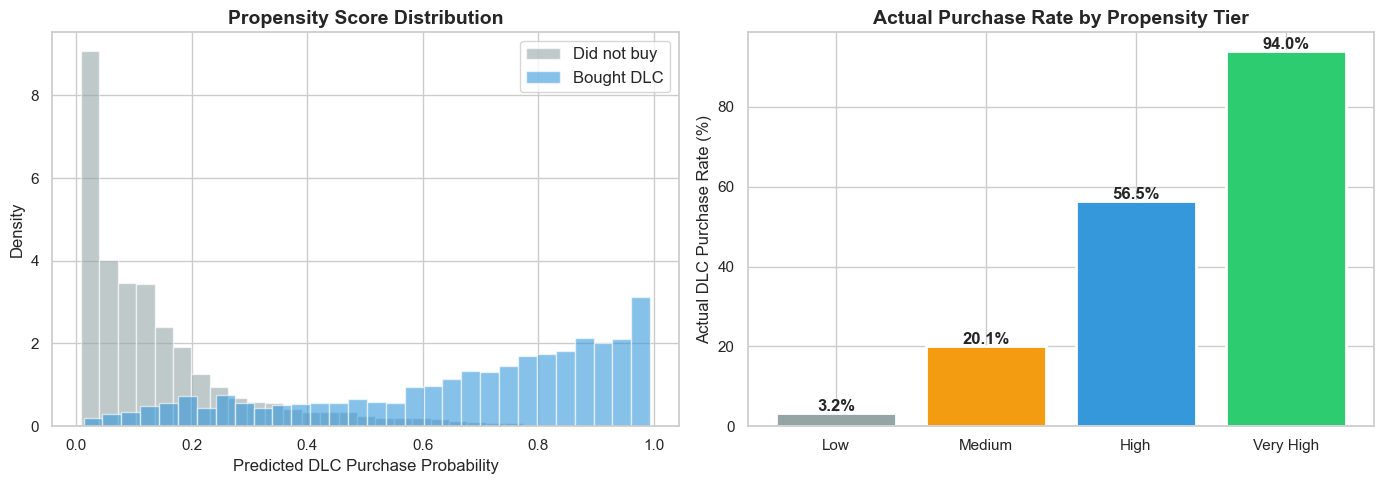

In [13]:
# Visualise
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Score distribution by outcome
axes[0].hist(prop_scores[prop_scores["actual_purchased"] == 0]["dlc_propensity"],
             bins=30, alpha=0.6, color="#95a5a6", label="Did not buy", density=True)
axes[0].hist(prop_scores[prop_scores["actual_purchased"] == 1]["dlc_propensity"],
             bins=30, alpha=0.6, color="#3498db", label="Bought DLC", density=True)
axes[0].set_title("Propensity Score Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Predicted DLC Purchase Probability")
axes[0].set_ylabel("Density")
axes[0].legend(fontsize=12)

# Right: Actual purchase rate by tier
tier_order = ["Low", "Medium", "High", "Very High"]
tier_rates = prop_scores.groupby("propensity_tier", observed=True)["actual_purchased"].mean().reindex(tier_order)
colors = ["#95a5a6", "#f39c12", "#3498db", "#2ecc71"]
available = [t for t in tier_order if t in tier_rates.index]
available_colors = [colors[tier_order.index(t)] for t in available]
bars = axes[1].bar(available, [tier_rates[t] * 100 for t in available],
                   color=available_colors, edgecolor="white", linewidth=2)
axes[1].set_title("Actual Purchase Rate by Propensity Tier", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Actual DLC Purchase Rate (%)")
for bar, t in zip(bars, available):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{tier_rates[t]:.1%}", ha="center", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

---
## Combining Churn Risk × Purchase Propensity

This is a preview of the **Next Best Action** framework we'll build in the next notebook.
By crossing churn risk with purchase propensity, we create a 2D map that tells the
marketing team exactly what to do with each player.

| | Low Propensity | High Propensity |
|---|---|---|
| **Low Churn Risk** | Leave alone (healthy, low-maintenance) | Upsell — ready to buy, not going anywhere |
| **High Churn Risk** | Retain first — they're leaving and not buying | Retain + Upsell — high value, at risk |

In [14]:
# Load churn scores from Step 3
churn_scores = pd.read_csv(DATA_DIR / "churn_scores.csv")

# Merge churn + propensity
combined = prop_scores[["player_id", "dlc_propensity", "propensity_tier"]].merge(
    churn_scores[["player_id", "churn_probability", "risk_tier"]],
    on="player_id", how="left"
)

# Players without churn scores are Free tier — assign them low churn risk
combined["churn_probability"] = combined["churn_probability"].fillna(0.0)
combined["risk_tier"] = combined["risk_tier"].fillna("Low Risk")

# Create 2x2 action quadrants
combined["churn_flag"] = (combined["churn_probability"] >= 0.35).astype(int)
combined["propensity_flag"] = (combined["dlc_propensity"] >= 0.40).astype(int)

def assign_quadrant(row):
    if row["churn_flag"] == 0 and row["propensity_flag"] == 0:
        return "Monitor"
    elif row["churn_flag"] == 0 and row["propensity_flag"] == 1:
        return "Upsell"
    elif row["churn_flag"] == 1 and row["propensity_flag"] == 0:
        return "Retain"
    else:
        return "Retain + Upsell"

combined["action_quadrant"] = combined.apply(assign_quadrant, axis=1)

# Summary
quad_summary = combined["action_quadrant"].value_counts()
print("Action Quadrant Distribution:\n")
for quadrant in ["Monitor", "Upsell", "Retain", "Retain + Upsell"]:
    count = quad_summary.get(quadrant, 0)
    pct = count / len(combined) * 100
    print(f"  {quadrant:<18s}: {count:>5,} players ({pct:.1f}%)")

Action Quadrant Distribution:

  Monitor           : 2,864 players (57.3%)
  Upsell            : 1,506 players (30.1%)
  Retain            :   590 players (11.8%)
  Retain + Upsell   :    40 players (0.8%)


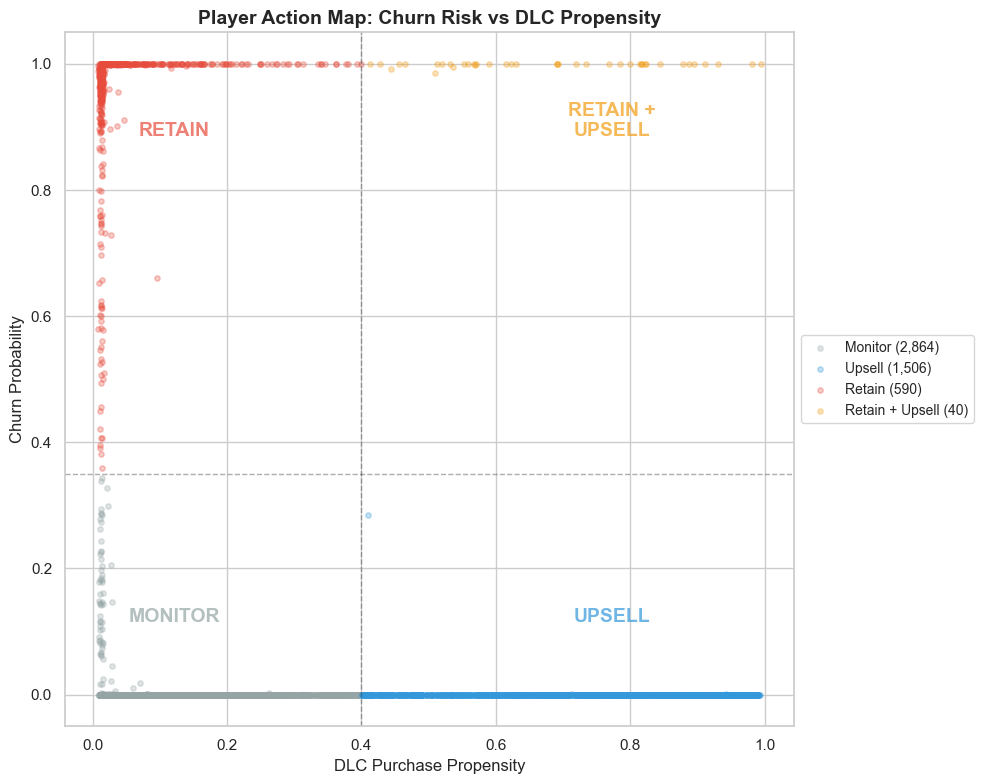

This scatter plot is the core of the Next Best Action framework.
Each player's position determines the optimal marketing action.


In [15]:
# Scatter plot: churn risk vs purchase propensity
fig, ax = plt.subplots(figsize=(10, 8))

quad_colors = {
    "Monitor": "#95a5a6",
    "Upsell": "#3498db",
    "Retain": "#e74c3c",
    "Retain + Upsell": "#f39c12",
}

for quadrant, color in quad_colors.items():
    subset = combined[combined["action_quadrant"] == quadrant]
    ax.scatter(subset["dlc_propensity"], subset["churn_probability"],
              alpha=0.3, s=15, c=color, label=f"{quadrant} ({len(subset):,})")

# Quadrant lines
ax.axhline(y=0.35, color="#333", linestyle="--", alpha=0.4, linewidth=1)
ax.axvline(x=0.40, color="#333", linestyle="--", alpha=0.4, linewidth=1)

# Quadrant labels
ax.text(0.15, 0.85, "RETAIN", fontsize=14, fontweight="bold", color="#e74c3c",
        ha="center", transform=ax.transAxes, alpha=0.7)
ax.text(0.75, 0.85, "RETAIN +\nUPSELL", fontsize=14, fontweight="bold", color="#f39c12",
        ha="center", transform=ax.transAxes, alpha=0.7)
ax.text(0.15, 0.15, "MONITOR", fontsize=14, fontweight="bold", color="#95a5a6",
        ha="center", transform=ax.transAxes, alpha=0.7)
ax.text(0.75, 0.15, "UPSELL", fontsize=14, fontweight="bold", color="#3498db",
        ha="center", transform=ax.transAxes, alpha=0.7)

ax.set_title("Player Action Map: Churn Risk vs DLC Propensity",
             fontsize=14, fontweight="bold")
ax.set_xlabel("DLC Purchase Propensity", fontsize=12)
ax.set_ylabel("Churn Probability", fontsize=12)
ax.legend(fontsize=10, loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

print("This scatter plot is the core of the Next Best Action framework.")
print("Each player's position determines the optimal marketing action.")

---
## Save Propensity Scores

In [16]:
# Save propensity scores
prop_output = prop_scores[["player_id", "dlc_propensity", "propensity_tier"]].copy()
prop_output.to_csv(DATA_DIR / "propensity_scores.csv", index=False)
print(f"Saved: {DATA_DIR / 'propensity_scores.csv'}")

# Save combined scores for NBA framework
combined.to_csv(DATA_DIR / "combined_scores.csv", index=False)
print(f"Saved: {DATA_DIR / 'combined_scores.csv'}")

# Model comparison
print(f"\n{'=' * 50}")
print(f"MODEL COMPARISON SUMMARY")
print(f"{'=' * 50}")
print(f"\n{'Model':<25s} {'ROC AUC':>9s} {'Avg Precision':>14s}")
print(f"{'-' * 50}")
print(f"  {'Logistic Regression':<23s} {lr_auc:>8.3f}  {lr_ap:>13.3f}")
print(f"  {'Gradient Boosting':<23s} {gb_auc:>8.3f}  {gb_ap:>13.3f}")

Saved: data/propensity_scores.csv
Saved: data/combined_scores.csv

MODEL COMPARISON SUMMARY

Model                       ROC AUC  Avg Precision
--------------------------------------------------
  Logistic Regression        0.863          0.746
  Gradient Boosting          0.857          0.742


---
## Summary

### What We Built
A gradient boosting propensity model that predicts paid DLC purchase likelihood for all
5,000 players, using the same Player 360 features as the churn model.

### Key Findings

1. **The Valhalla signal is real** — `claimed_valhalla` appears as a meaningful predictor.
   Players who engage with free DLC are significantly more likely to purchase paid DLC.
   This validates a specific, actionable personalisation strategy: use free content as a funnel.

2. **Propensity tiers are well-calibrated** — actual purchase rates increase monotonically
   across predicted tiers, meaning the model's confidence translates to real-world likelihood.

3. **The Churn × Propensity action map** creates four clear strategic quadrants:
   - **Monitor** (low risk, low propensity) — healthy, low-maintenance players
   - **Upsell** (low risk, high propensity) — prime targets for DLC offers
   - **Retain** (high risk, low propensity) — focus on keeping them, not selling to them
   - **Retain + Upsell** (high risk, high propensity) — most valuable intervention targets

### How PlayStation Would Use This

The propensity model enables **right message, right player, right time** marketing:
- When new DLC drops, target the 'High' and 'Very High' propensity tiers first
- For free DLC releases, track who claims it — they become warm leads for future paid content
- Combine with churn scores to avoid pushing purchase offers to players who are about to leave
  (fix the relationship first, sell later)

**Next: [05_clv_and_next_best_action.ipynb](05_clv_and_next_best_action.ipynb)** — Estimating
player lifetime value and combining all scores into the decision framework.